In [75]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from datetime import datetime, timedelta
from calendar import monthrange
from salishsea_tools import stormtools, places
from matplotlib.colors import LogNorm
from windrose import WindroseAxes
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
plt.rcParams['font.size'] = 12

In [3]:
# Specify daterange
daterange = [datetime(2015, 1, 1), datetime(2019, 1, 1)]

# Load HRDPS
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

# Preallocate storage dictionaries
stations = [
    {'ECname': 'Sandheads'    , 'MOADname': 'Sandheads'},
    {'ECname': 'SistersIsland', 'MOADname': 'Sisters Islet'},
]
for station in stations:
    for key in ['obs', 'HRDPS']:
        station[key] = {'spd': np.empty(0), 'dir': np.empty(0), 'time': np.empty(0)}

In [4]:
# Load EC observations over 4 year period
for year in tqdm(range(2015, 2019)):
    for month in range(1, 13):
        
        # Loop through stations
        for station in stations:
            
            # Define month boundaries
            start = datetime(year, month, 1).strftime('%d-%b-%Y')
            end = datetime(year, month, monthrange(year, month)[1]).strftime('%d-%b-%Y')
            
            # Load data into dict
            wspd, wdir, _, wtime, _, _ = stormtools.get_EC_observations(station['ECname'], start, end)
            station['obs']['spd'] = np.concatenate((station['obs']['spd'], wspd))
            station['obs']['dir'] = np.concatenate((station['obs']['dir'], wdir))
            station['obs']['time'] = np.concatenate((station['obs']['time'], wtime))

In [5]:
# Process HRDPS wind data from ERDDAP in ~6 month chunks
hours = int(np.diff(daterange)[0].total_seconds() / 3600)
chunk = int(hours / 8)
for hour in tqdm(range(0, hours, chunk)):

    # Date slice for current chunk
    dslc = slice(*[daterange[0] + timedelta(hours=h) for h in (hour, hour+chunk-1)])
    
    # Loop through stations
    for station in stations:
    
        # Extract u and v along sections
        j, i = places.PLACES[station['MOADname']]['GEM2.5 grid ji']
        u = HRDPS.sel(time=dslc).isel(gridY=j, gridX=i).u_wind.values
        v = HRDPS.sel(time=dslc).isel(gridY=j, gridX=i).v_wind.values
        wtime = HRDPS.sel(time=dslc).time.values.astype('datetime64[s]').astype(datetime)
        
        # Wind angle
        wdir = 180 * np.arctan2(v, u) / np.pi
        wdir[wdir < 0] = wdir[wdir < 0] + 360
        wdir = wdir - 7
        
        # Update arrays
        station['HRDPS']['spd'] = np.concatenate((station['HRDPS']['spd'], np.sqrt(u**2 + v**2)))
        station['HRDPS']['dir'] = np.concatenate((station['HRDPS']['dir'], wdir - 7))
        station['HRDPS']['time'] = np.concatenate((station['HRDPS']['time'], wtime))

***

## Sandheads

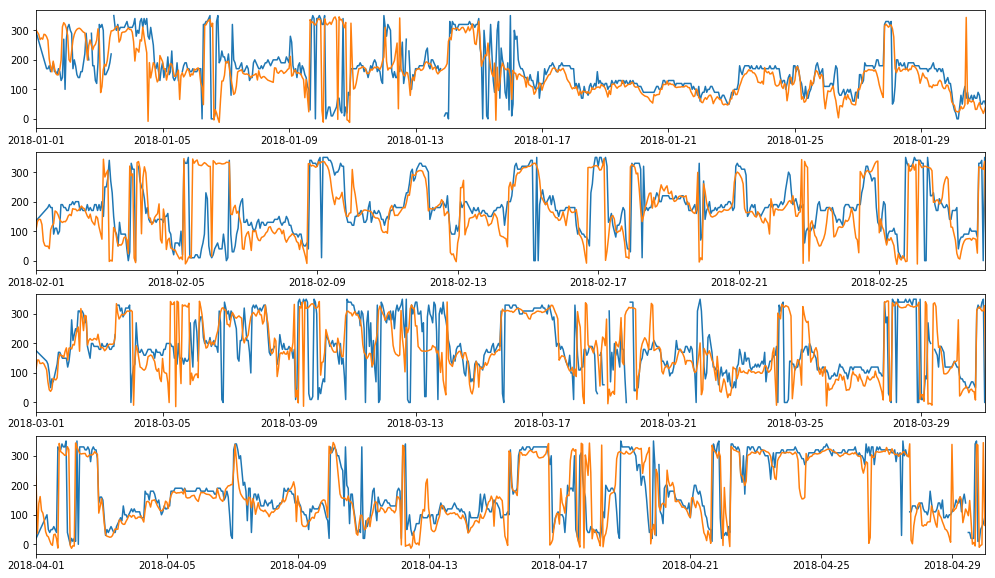

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(17, 10))

for ax, month in zip(axs, range(1, 5)):
    ax.plot(stations[0]['obs']['time'], stations[0]['obs']['dir'])
    ax.plot(stations[0]['HRDPS']['time'], stations[0]['HRDPS']['dir'])
    ax.set_xlim([datetime(2018, month, 1), datetime(2018, month, monthrange(2018, month)[1])])

***

## Sisters Islet

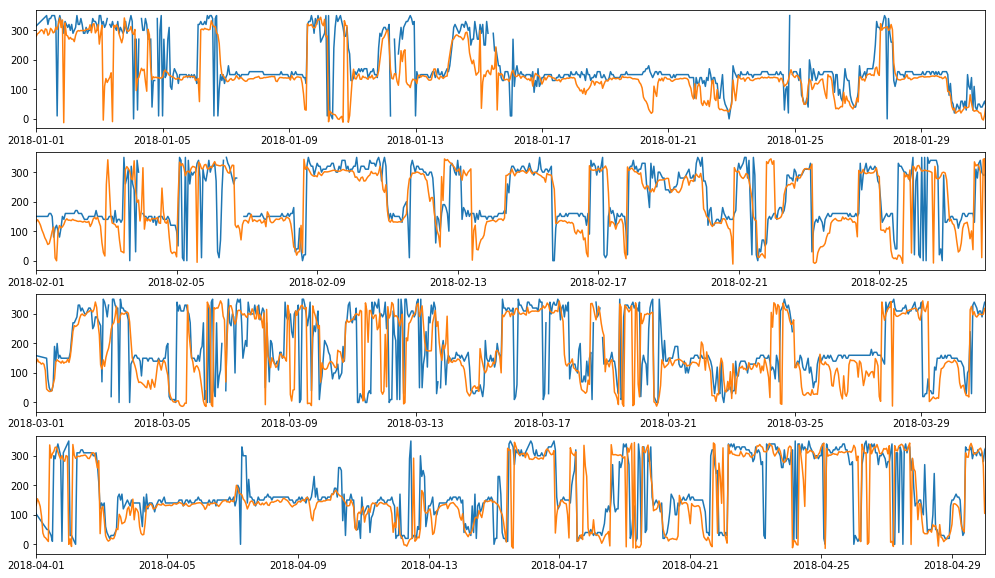

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(17, 10))

for ax, month in zip(axs, range(1, 5)):
    ax.plot(stations[1]['obs']['time'], stations[1]['obs']['dir'])
    ax.plot(stations[1]['HRDPS']['time'], stations[1]['HRDPS']['dir'])
    ax.set_xlim([datetime(2018, month, 1), datetime(2018, month, monthrange(2018, month)[1])])

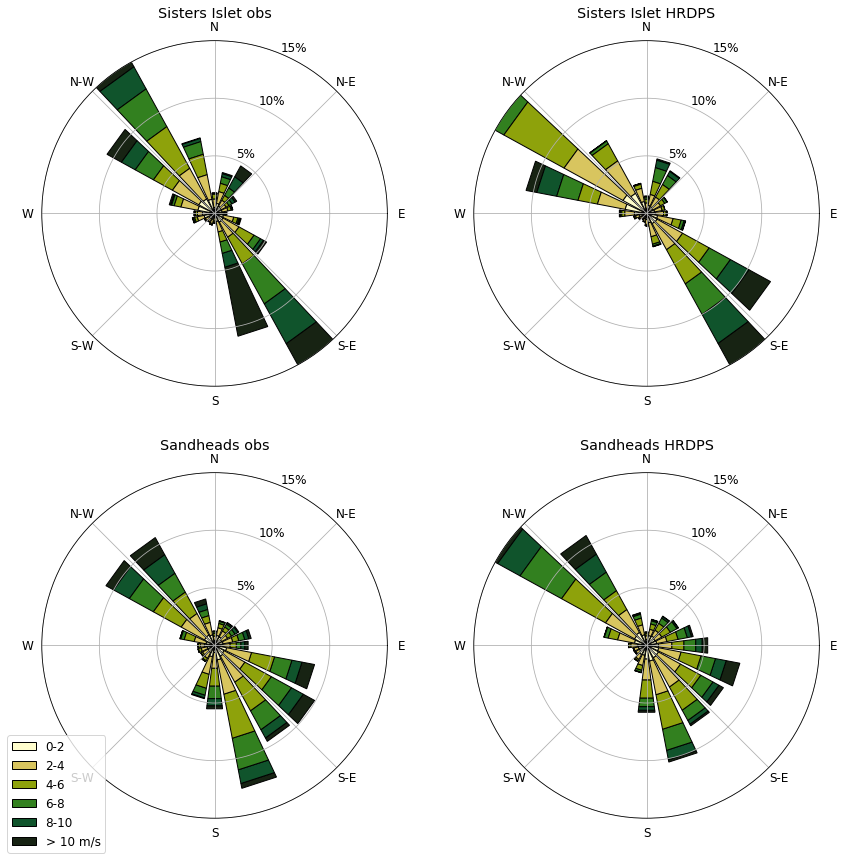

In [92]:
# Make windrose plot using Python Windrose library
# https://windrose.readthedocs.io/en/latest/
#
# Brief example
# ------------------
#
# pip install windrose
#
# from windrose import WindroseAxes
#
# ax = WindroseAxes.from_ax()
# ax.bar(dir, spd, normed=True, opening=0.8, edgecolor='k')
# ax.set_legend()
#
# ------------------

# Plot params
bins = range(0, 11, 2)
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
labels.append(f'> {bins[-1]} m/s')
ticks = [5, 10, 15]

# Make figure
fig = plt.figure(figsize=(12, 12))

# Loop through stations and records
for station, ypos in zip(stations, [0, 0.5]):
    for record, xpos in zip(['obs', 'HRDPS'], [0, 0.5]):

        # Make windrose object
        ax = WindroseAxes.from_ax(fig=fig)
        ax.set_position([xpos, ypos, 0.4, 0.4])
        
        # Plot wind data
        ax.bar(
            station[record]['dir'], station[record]['spd'], bins=bins,
            nsector=20, normed=True, opening=0.8, edgecolor='k', cmap=cm.speed,
        )
        
        # Formatting axis
        ax.set_ylim([0, 15])
        ax.yaxis.set_ticks(ticks)
        ax.yaxis.set_ticklabels([f'{tick}%' for tick in ticks]) # Need because windrose screws this up
        ax.set_title(f"{station['MOADname']} {record}")
        
        # Add legend (hacked to allow custom labels)
        if (ypos == 0) and (xpos == 0):
            l = ax.legend(loc=(-0.1, -0.1))
            for i, label in zip(range(len(labels)), labels):
                l.get_texts()[i].set_text(label) 